In [1]:
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from geopy import distance
from datetime import datetime
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
weather_set_dirty = pd.read_csv('../Data_Cleanup/inCSV/Weather_LosAngeles.csv', sep=",")
weather_set_dirty['timestamp'] = pd.to_datetime(weather_set_dirty['timestamp'])

mean_values_by_day = weather_set_dirty.groupby(weather_set_dirty["timestamp"].dt.date).mean(numeric_only=True).round(1)

for col in mean_values_by_day.columns:
    weather_set_dirty[col] = weather_set_dirty.apply(
        lambda row: mean_values_by_day.loc[row['timestamp'].date(), col]
        if pd.isnull(row[col]) else row[col],
        axis=1
    )

weather_set_dirty['cloud_cover_description'].fillna(method='ffill',inplace=True)

weather_set_dirty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77362 entries, 0 to 77361
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   city                     77362 non-null  object        
 1   timestamp                77362 non-null  datetime64[ns]
 2   temperature              77362 non-null  float64       
 3   cloud_cover              77362 non-null  float64       
 4   cloud_cover_description  77362 non-null  object        
 5   pressure                 77362 non-null  float64       
 6   windspeed                77362 non-null  float64       
 7   precipitation            77362 non-null  float64       
 8   felt_temperature         77362 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 5.3+ MB


In [3]:
bike_set_dirty = pd.read_csv('../Data_Cleanup/inCSV/metro_2017_2022.csv', sep=',', index_col=0)

bike_set_dirty.sort_values('start_station_id')
bike_set_dirty['start_station_lat'].fillna(method="ffill", inplace=True)
bike_set_dirty['start_station_lon'].fillna(method="ffill", inplace=True)

bike_set_dirty.sort_values('end_station_id')
bike_set_dirty['end_station_lat'].fillna(method="ffill", inplace=True)
bike_set_dirty['end_station_lon'].fillna(method="ffill", inplace=True)

bike_set_dirty_agg_start = bike_set_dirty.groupby('start_station_id')[['start_station_lat', 'start_station_lon']].agg(lambda x: x.mode().iloc[0])
bike_set_dirty_agg_end = bike_set_dirty.groupby('end_station_id')[['end_station_lat', 'end_station_lon']].agg(lambda x: x.mode().iloc[0])

bike_set_dirty_merge = bike_set_dirty.merge(bike_set_dirty_agg_start, on='start_station_id', suffixes=('','_mode'))
bike_set_dirty_merged = bike_set_dirty_merge.merge(bike_set_dirty_agg_end, on='end_station_id', suffixes=('','_mode'))

dateformat0 = "%H/%M/%S %d-%m-%Y"
dateformat1 = "%Y-%m-%d %H:%M:%S"
for i, row in bike_set_dirty_merged.iterrows():
    bike_set_dirty_merged.at[i, 'start_station_lat'] = bike_set_dirty_merged.loc[i, 'start_station_lat_mode']
    bike_set_dirty_merged.at[i, 'start_station_lon'] = bike_set_dirty_merged.loc[i, 'start_station_lon_mode']
    bike_set_dirty_merged.at[i, 'end_station_lat'] = bike_set_dirty_merged.loc[i, 'end_station_lat_mode']
    bike_set_dirty_merged.at[i, 'end_station_lon'] = bike_set_dirty_merged.loc[i, 'end_station_lon_mode']

    try:
        bike_set_dirty_merged.at[i, 'start_time'] = datetime.strptime(bike_set_dirty_merged.loc[i, 'start_time'], dateformat0)
    except ValueError:
        bike_set_dirty_merged.at[i, 'start_time'] = datetime.strptime(bike_set_dirty_merged.loc[i, 'start_time'], dateformat1)
    try:
        bike_set_dirty_merged.at[i, 'end_time'] = datetime.strptime(bike_set_dirty_merged.loc[i, 'end_time'], dateformat0)
    except ValueError:
        bike_set_dirty_merged.at[i, 'end_time'] = datetime.strptime(bike_set_dirty_merged.loc[i, 'end_time'], dateformat1)

bike_set_almost_clean = bike_set_dirty_merged
bike_set_clean = bike_set_almost_clean.drop(['start_station_lat_mode', 'start_station_lon_mode', 'end_station_lat_mode', 'end_station_lon_mode'], axis=1)
bike_set_clean['start_time'] = pd.to_datetime(bike_set_almost_clean['start_time'], format="%Y-%m-%d %H:%M:%S")
bike_set_clean['end_time'] = pd.to_datetime(bike_set_almost_clean['end_time'], format="%Y-%m-%d %H:%M:%S")
bike_set_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1552782 entries, 0 to 1552781
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   start_time         1552782 non-null  datetime64[ns]
 1   end_time           1552782 non-null  datetime64[ns]
 2   start_station_id   1552782 non-null  int64         
 3   start_station_lat  1552782 non-null  float64       
 4   start_station_lon  1552782 non-null  float64       
 5   end_station_id     1552782 non-null  int64         
 6   end_station_lat    1552782 non-null  float64       
 7   end_station_lon    1552782 non-null  float64       
 8   bike_id            1552782 non-null  object        
dtypes: datetime64[ns](2), float64(4), int64(2), object(1)
memory usage: 150.7+ MB


In [4]:
metro = bike_set_clean
metro['idle_time'] = None
metro = metro.sort_values(by='end_time')

BigDict = {
    # station_id: {
    #     transaction_id: end_time
    # }
}

for i, row in metro.iterrows():
    current_start_time = row["start_time"]
    current_end_time = row["end_time"]
    current_end_station_id = row["end_station_id"]
    current_start_station_id = row["start_station_id"]
    current_bike_id = row["bike_id"]
    current_transaction_id = i

    if current_start_station_id in BigDict:
        for transaction in list(BigDict[current_start_station_id]):  # Create a copy of the keys
            if current_start_time < BigDict[current_start_station_id][transaction]:
                continue
            if metro.at[transaction, "idle_time"] is not None:
                continue
            idle_time = current_start_time - BigDict[current_start_station_id][transaction]
            metro.at[transaction, "idle_time"] = idle_time
            #if idle_time.total_seconds() >= 0:
            del BigDict[current_start_station_id][transaction]

    if current_end_station_id not in BigDict:
        BigDict[current_end_station_id] = {current_transaction_id: current_end_time}

    BigDict[current_end_station_id][current_transaction_id] = current_end_time

metro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1552782 entries, 690312 to 373108
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   start_time         1552782 non-null  datetime64[ns]
 1   end_time           1552782 non-null  datetime64[ns]
 2   start_station_id   1552782 non-null  int64         
 3   start_station_lat  1552782 non-null  float64       
 4   start_station_lon  1552782 non-null  float64       
 5   end_station_id     1552782 non-null  int64         
 6   end_station_lat    1552782 non-null  float64       
 7   end_station_lon    1552782 non-null  float64       
 8   bike_id            1552782 non-null  object        
 9   idle_time          1551807 non-null  object        
dtypes: datetime64[ns](2), float64(4), int64(2), object(2)
memory usage: 162.6+ MB


In [5]:
metro = metro.sort_values(by='start_time')
#Create the corresponding columns
metro["morgens"] = 0
metro["vormittags"] = 0
metro["mittags"] = 0
metro["nachmittags"]=0
metro["abends"]=0
metro["nachts"]=0

#set the start and end of each day time
morgens = range(5,9)
vormittags = range(9,12)
mittags = range(12,15)
nachmittags = range(15,19)
abends = range(19, 23)
nachts = [23,0,1,2,3,4]

#This list will serve as string provider that we can insert later, to access the proper column
TagesZeiten = ["morgens", "vormittags", "mittags", "nachmittags", "abends", "nachts"]
#This list will serve to provide the start time of each day time, so we know when to change columns
Intervall_starts = [5,9,12,15,19,23]

metro["monday"] = 0
metro["tuesday"] = 0
metro["wednesday"] = 0
metro["thursday"] = 0
metro["friday"] = 0
metro["saturday"] = 0
metro["sunday"] = 0

Days = ["monday","tuesday","wednesday", "thursday","friday","saturday", "sunday"]

#Make sure to change the "idle_time" to a timedelta object, so we can use .totalseconds() later
metro["idle_time"] = pd.to_timedelta(metro["idle_time"])

# Iterate through each row in the DataFrame
for i, row in metro.iterrows():
    end_date = row["end_time"] + row["idle_time"]
    #we only need the starting time hour
    end_hour = end_date.hour
    # and we need to know the duration (idle time) we need to look back
    idle_time = row["idle_time"]
    # make sure to skip any rows with no idle times, since they have 0s in the day times columns
    try:
        NumHours = float(idle_time.total_seconds() / 3600)
        if end_hour in morgens:
            index = 0
        elif end_hour in vormittags:
            index = 1
        elif end_hour in mittags:
            index = 2
        elif end_hour in nachmittags:
            index = 3
        elif end_hour in abends:
            index = 4
        elif end_hour in nachts:
            index = 5

        while NumHours >0 and index > -6:
            metro.at[i, TagesZeiten[index]] = 1
            DistanceToIntervallStart = abs(Intervall_starts[index]- end_hour)

            NumHours -= DistanceToIntervallStart
            end_hour -= DistanceToIntervallStart
            index -= 1

        NumDays = float(row["idle_time"].total_seconds() / (24 * 60 * 60))

        day = end_date.weekday()

        while NumDays > 0 and day > -7:
            metro.at[i, Days[day]] = 1

            NumDays -= 1
            day -= 1

    except ValueError:
        continue


In [6]:
weather_set = weather_set_dirty
metro_set = metro

In [7]:
weather_set.info(), metro_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77362 entries, 0 to 77361
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   city                     77362 non-null  object        
 1   timestamp                77362 non-null  datetime64[ns]
 2   temperature              77362 non-null  float64       
 3   cloud_cover              77362 non-null  float64       
 4   cloud_cover_description  77362 non-null  object        
 5   pressure                 77362 non-null  float64       
 6   windspeed                77362 non-null  float64       
 7   precipitation            77362 non-null  float64       
 8   felt_temperature         77362 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 5.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1552782 entries, 690312 to 827163
Data columns (total 23 columns):
 #   Column             Non-Null 

(None, None)

In [8]:
metro_set.sort_values('start_time', inplace=True)
weather_set.sort_values('timestamp', inplace=True)

Weather_Set1 = weather_set.set_index('timestamp').reindex(metro_set.set_index('start_time').index, method='nearest')
Weather_Set1 = Weather_Set1.loc[~Weather_Set1.index.duplicated(keep='first')].reset_index()

merged_set = pd.merge(metro_set, Weather_Set1, on='start_time', how='left')
merged_set = merged_set.drop(['city'], axis=1)
merged_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1552782 entries, 0 to 1552781
Data columns (total 30 columns):
 #   Column                   Non-Null Count    Dtype          
---  ------                   --------------    -----          
 0   start_time               1552782 non-null  datetime64[ns] 
 1   end_time                 1552782 non-null  datetime64[ns] 
 2   start_station_id         1552782 non-null  int64          
 3   start_station_lat        1552782 non-null  float64        
 4   start_station_lon        1552782 non-null  float64        
 5   end_station_id           1552782 non-null  int64          
 6   end_station_lat          1552782 non-null  float64        
 7   end_station_lon          1552782 non-null  float64        
 8   bike_id                  1552782 non-null  object         
 9   idle_time                1551807 non-null  timedelta64[ns]
 10  morgens                  1552782 non-null  int64          
 11  vormittags               1552782 non-null  int64  

In [9]:
merged_set_descriptive = merged_set
mean_idle_time = merged_set_descriptive.groupby("end_station_id")["idle_time"].mean()

count_morning = merged_set_descriptive.groupby("end_station_id")["morgens"].sum()
count_vormittag = merged_set_descriptive.groupby("end_station_id")["vormittags"].sum()
count_midday = merged_set_descriptive.groupby("end_station_id")["mittags"].sum()
count_afternoon = merged_set_descriptive.groupby("end_station_id")["nachmittags"].sum()
count_evening = merged_set_descriptive.groupby("end_station_id")["abends"].sum()
count_night = merged_set_descriptive.groupby("end_station_id")["nachts"].sum()
count_mondays = merged_set_descriptive.groupby("end_station_id")["monday"].sum()
count_tuesdays = merged_set_descriptive.groupby("end_station_id")["tuesday"].sum()
count_wednesdays = merged_set_descriptive.groupby("end_station_id")["wednesday"].sum()
count_thursdays = merged_set_descriptive.groupby("end_station_id")["thursday"].sum()
count_fridays = merged_set_descriptive.groupby("end_station_id")["friday"].sum()
count_saturdays = merged_set_descriptive.groupby("end_station_id")["saturday"].sum()
count_sundays = merged_set_descriptive.groupby("end_station_id")["sunday"].sum()
station_lat = merged_set_descriptive.groupby("end_station_id")["end_station_lat"].unique()
station_lon = merged_set_descriptive.groupby("end_station_id")["end_station_lon"].unique()

result = pd.concat([mean_idle_time, count_morning, count_vormittag, count_midday, count_afternoon, count_evening, count_night, count_mondays, count_tuesdays, count_wednesdays, count_thursdays, count_fridays, count_saturdays, count_sundays, station_lat, station_lon], axis=1)
station_ID_with_AvgIdleDaytimesDays_and_lonlat = result.dropna(subset=["idle_time"])
station_ID_with_AvgIdleDaytimesDays_and_lonlat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 3000 to 4638
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   idle_time        394 non-null    timedelta64[ns]
 1   morgens          394 non-null    int64          
 2   vormittags       394 non-null    int64          
 3   mittags          394 non-null    int64          
 4   nachmittags      394 non-null    int64          
 5   abends           394 non-null    int64          
 6   nachts           394 non-null    int64          
 7   monday           394 non-null    int64          
 8   tuesday          394 non-null    int64          
 9   wednesday        394 non-null    int64          
 10  thursday         394 non-null    int64          
 11  friday           394 non-null    int64          
 12  saturday         394 non-null    int64          
 13  sunday           394 non-null    int64          
 14  end_station_lat  394 n

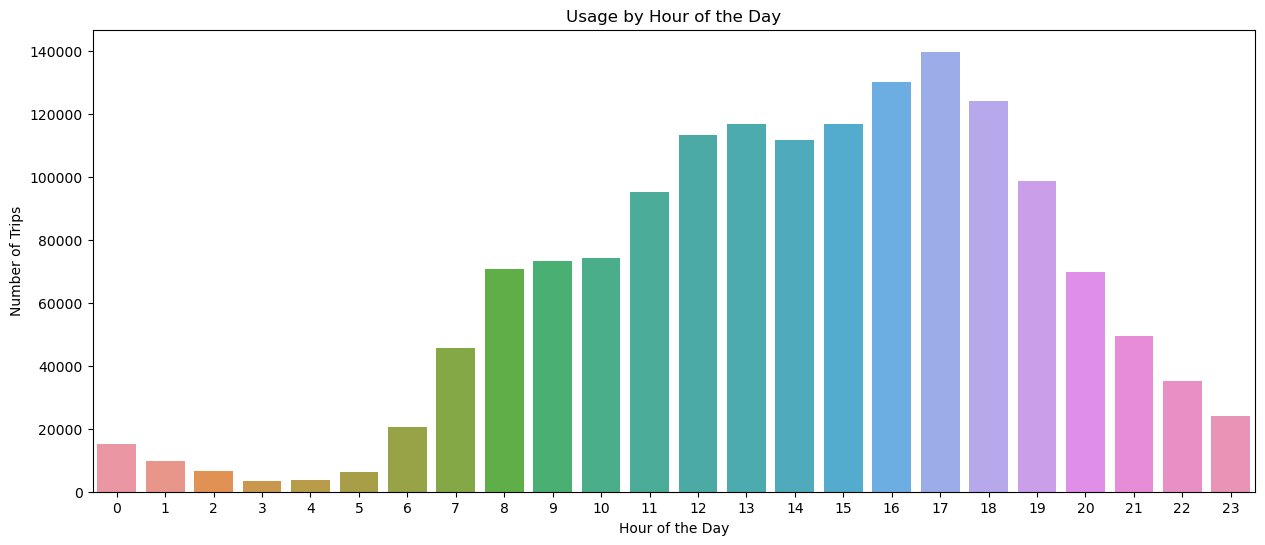

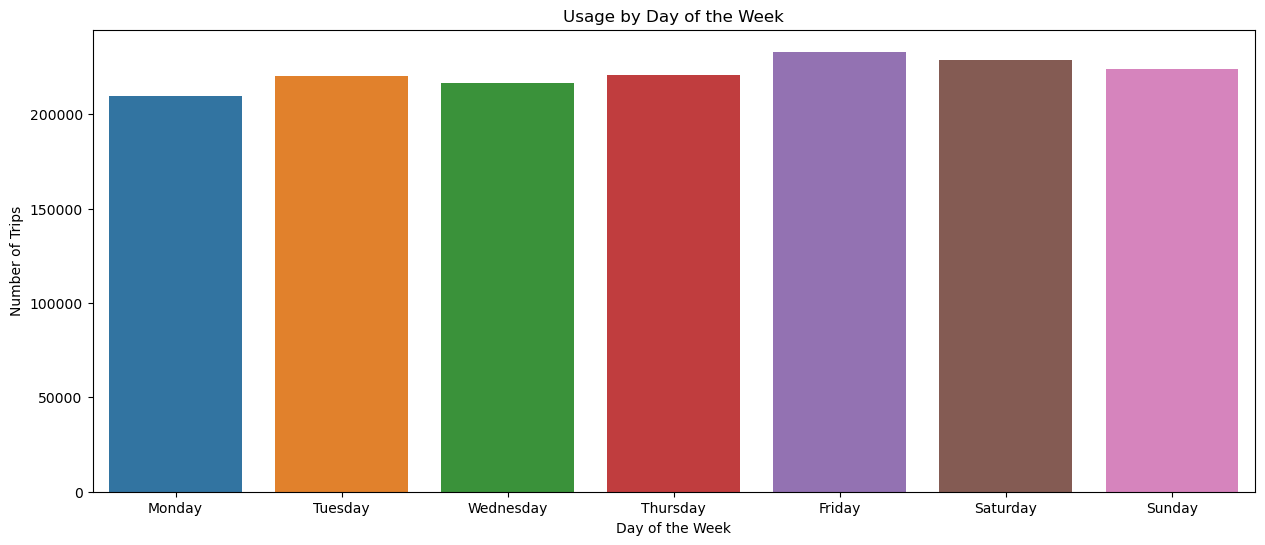

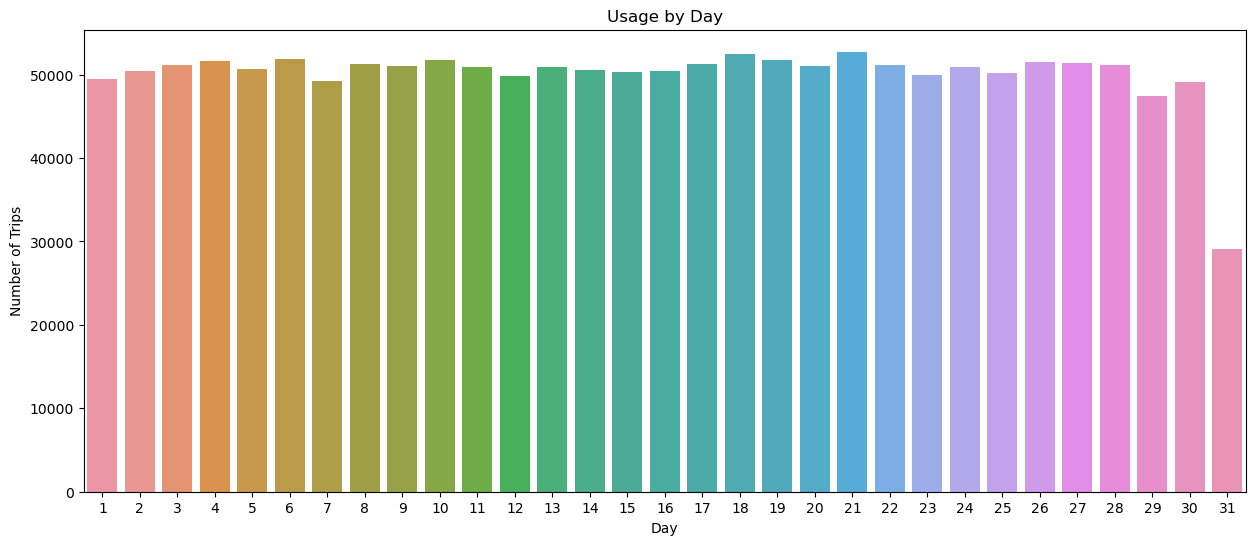

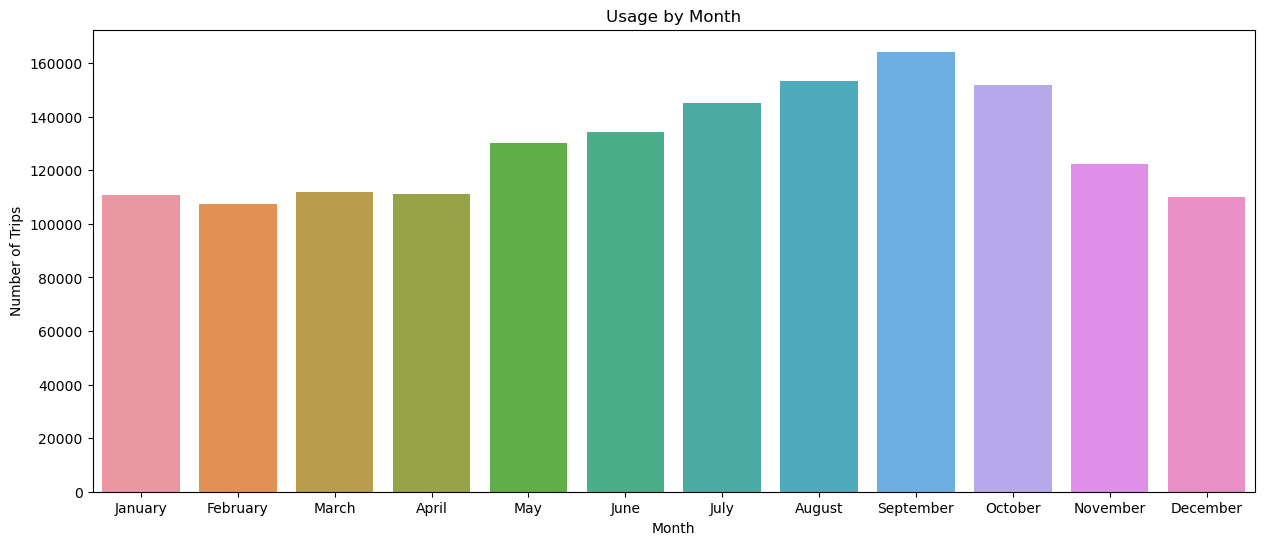

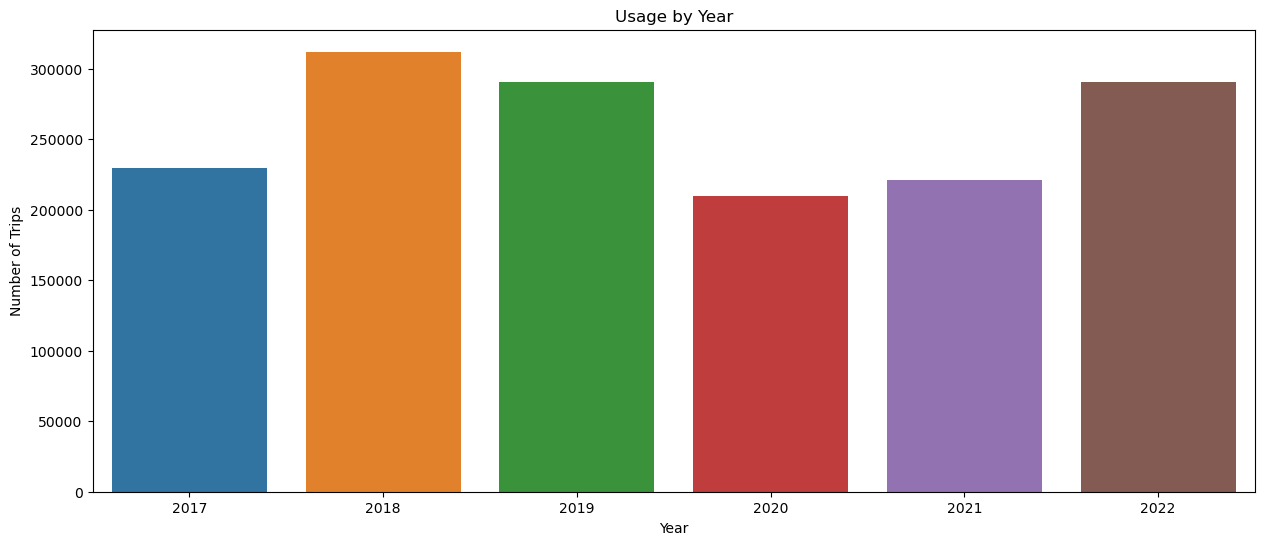

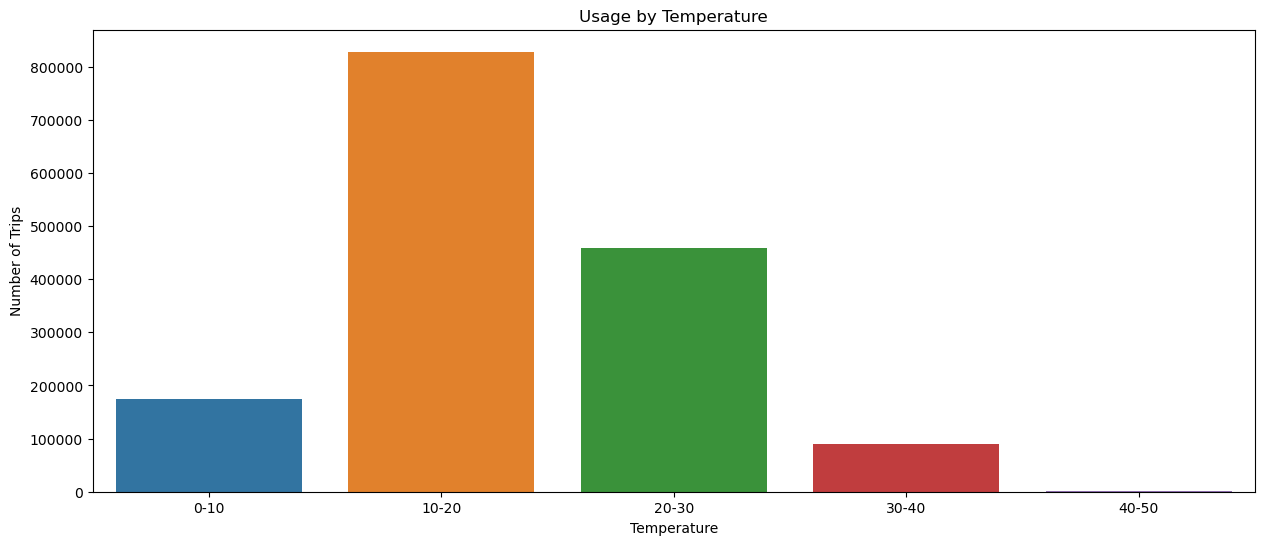

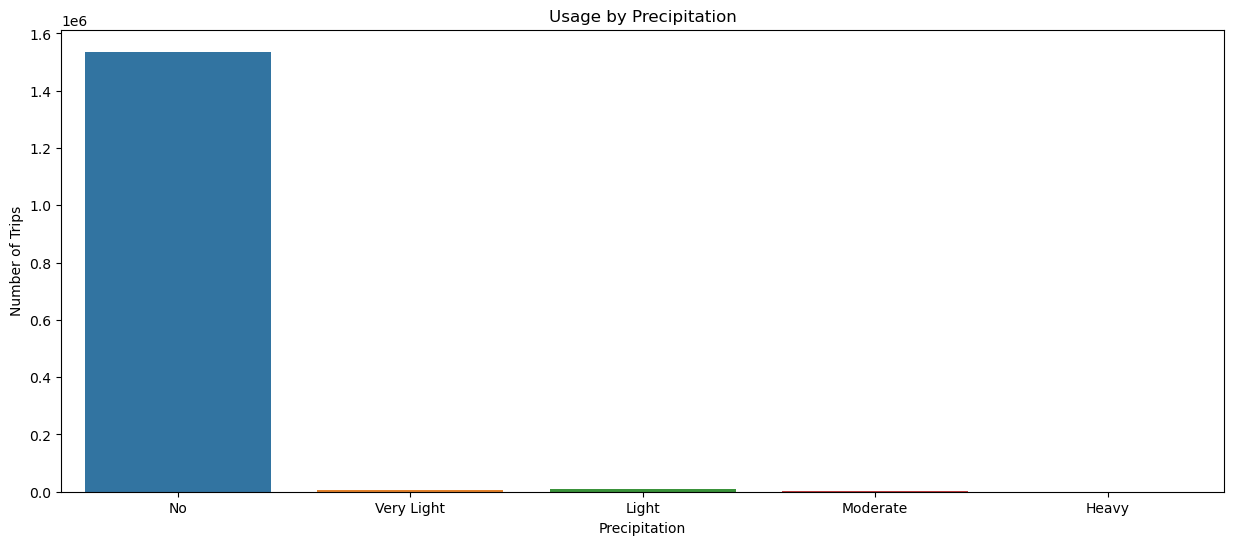

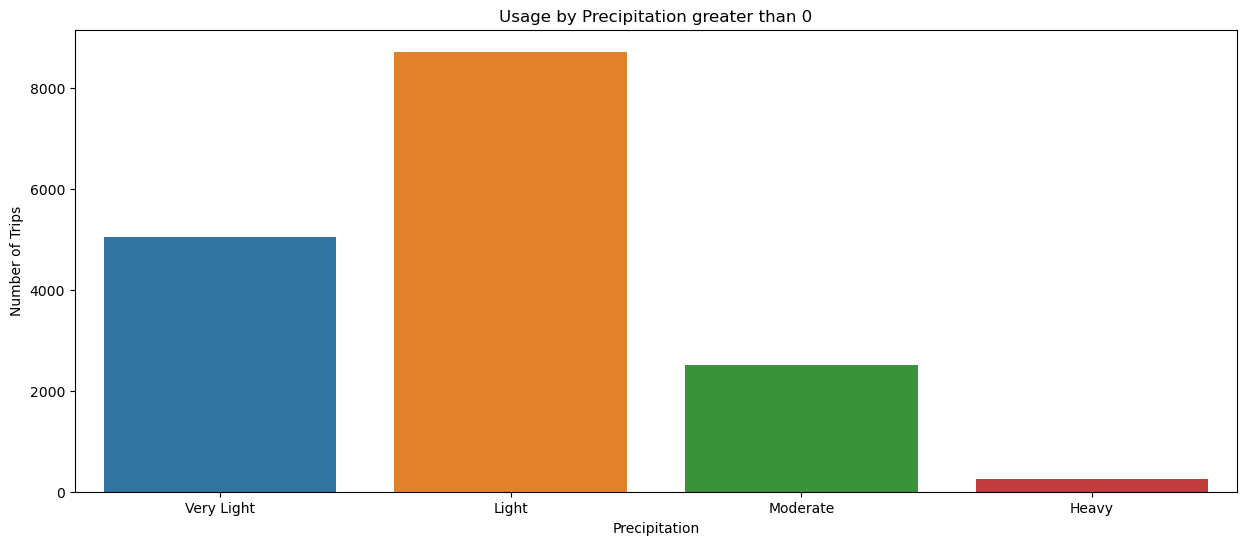

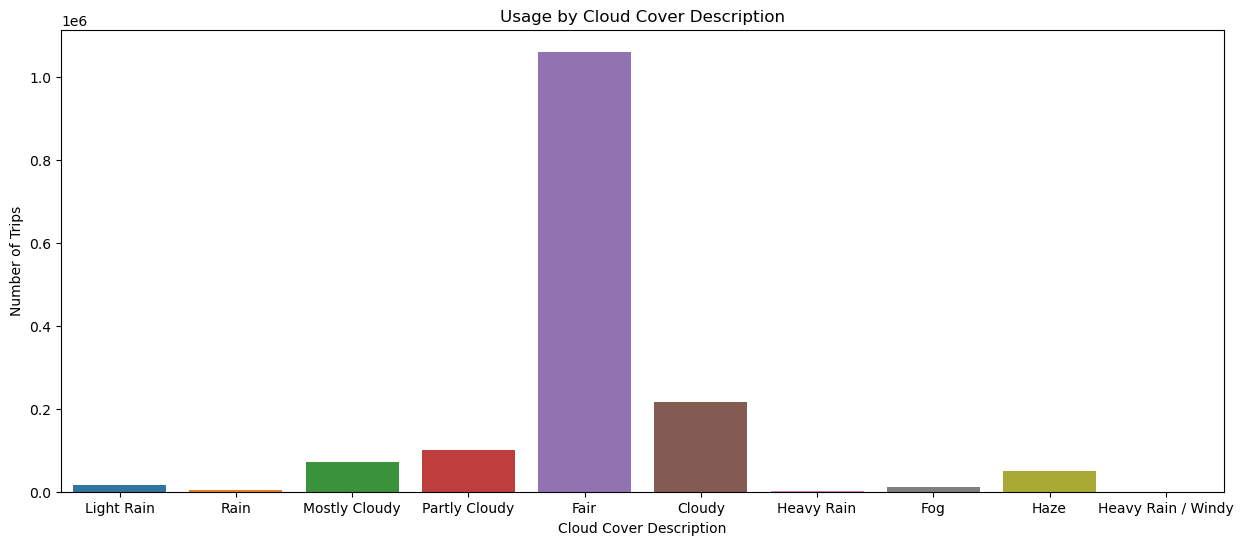

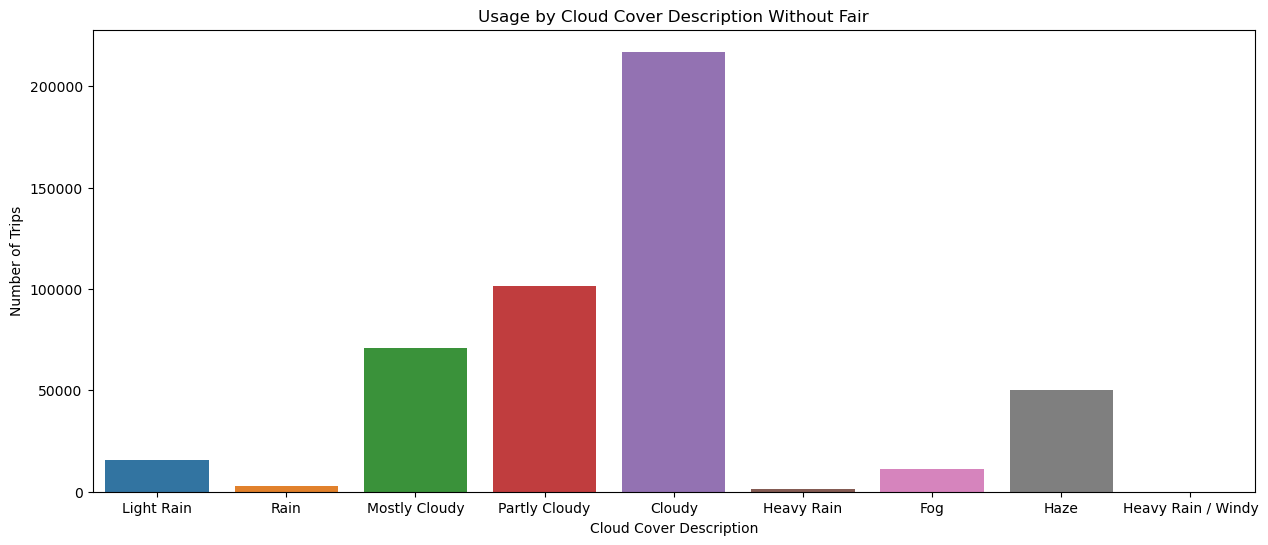

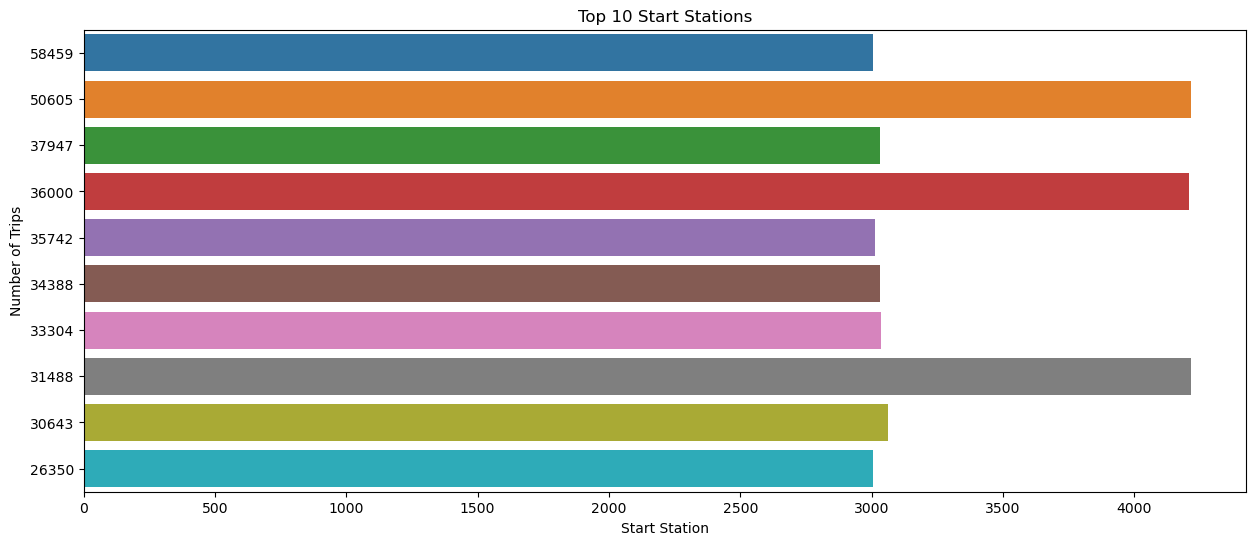

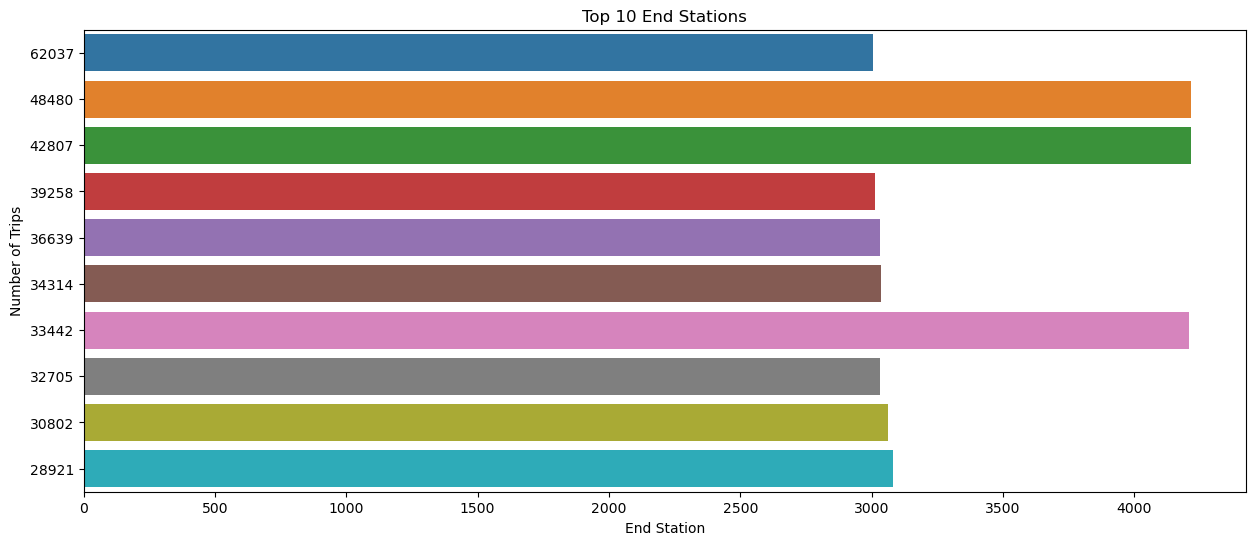

In [10]:
data = merged_set_descriptive.copy()

data['start_time'] = pd.to_datetime(data['start_time'])
data['end_time'] = pd.to_datetime(data['end_time'])
data['trip_duration'] = (data['end_time'] - data['start_time']).dt.total_seconds() / 60

data['hour'] = data['start_time'].dt.hour
data['weekday'] = data['start_time'].dt.day_name()
data['day'] = data['start_time'].dt.day
data['month'] = data['start_time'].dt.month_name()
data['year'] = data['start_time'].dt.year

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['weekday'] = pd.Categorical(data['weekday'], categories=weekday_order, ordered=True)
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
data['month'] = pd.Categorical(data['month'], categories=month_order, ordered=True)

usage_by_hour = data['hour'].value_counts().sort_index()
usage_by_weekday = data['weekday'].value_counts().sort_index()
usage_by_day = data['day'].value_counts().sort_index()
usage_by_month = data['month'].value_counts().sort_index()
usage_by_year = data['year'].value_counts().sort_index()

usage_by_start_station = data['start_station_id'].value_counts().head(10)
usage_by_end_station = data['end_station_id'].value_counts().head(10)

bins = [0, 10, 20, 30, 40, 50]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50']
data['temperature_bin'] = pd.cut(data['temperature'], bins=bins, labels=labels)
usage_by_temperature = data['temperature_bin'].value_counts()


bins = [-np.inf, 0, 0.5, 2.5, 7.6, np.inf]
labels = ['No', 'Very Light', 'Light', 'Moderate', 'Heavy']
data['precipitation_category'] = pd.cut(data['precipitation'], bins=bins, labels=labels)
usage_by_precipitation = data['precipitation_category'].value_counts()

data_with_precipitation = data[data['precipitation'] > 0].copy()
bins = [0, 0.5, 2.5, 7.6, np.inf]
labels = ['Very Light', 'Light', 'Moderate', 'Heavy']
data_with_precipitation['precipitation_category'] = pd.cut(data_with_precipitation['precipitation'], bins=bins, labels=labels)
usage_by_precipitation2 = data_with_precipitation['precipitation_category'].value_counts()

cloud_cover_categories = ['Light Rain', 'Rain', 'Mostly Cloudy', 'Partly Cloudy', 'Fair', 'Cloudy', 'Heavy Rain', 'Fog', 'Haze', 'Heavy Rain / Windy']
data['cloud_cover_description'] = pd.Categorical(data['cloud_cover_description'], categories=cloud_cover_categories, ordered=True)
usage_by_cloud_cover = data['cloud_cover_description'].value_counts().sort_index()

data_without_fair = data[data['cloud_cover_description'] != 'Fair'].copy()
cloud_cover_categories2 = ['Light Rain', 'Rain', 'Mostly Cloudy', 'Partly Cloudy', 'Cloudy', 'Heavy Rain', 'Fog', 'Haze', 'Heavy Rain / Windy']
data_without_fair['cloud_cover_description'] = pd.Categorical(data_without_fair['cloud_cover_description'], categories=cloud_cover_categories2, ordered=True)
usage_by_cloud_cover2 = data_without_fair['cloud_cover_description'].value_counts().sort_index()

def bar_plot(usage, title, xlabel, ylabel):
    plt.figure(figsize=(15,6))
    sns.barplot(x=usage.index, y=usage.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


bar_plot(usage_by_hour, 'Usage by Hour of the Day', 'Hour of the Day', 'Number of Trips')
bar_plot(usage_by_weekday, 'Usage by Day of the Week', 'Day of the Week', 'Number of Trips')
bar_plot(usage_by_day, 'Usage by Day', 'Day', 'Number of Trips')
bar_plot(usage_by_month, 'Usage by Month', 'Month', 'Number of Trips')
bar_plot(usage_by_year, 'Usage by Year', 'Year', 'Number of Trips')
bar_plot(usage_by_temperature, 'Usage by Temperature', 'Temperature', 'Number of Trips')
bar_plot(usage_by_precipitation, 'Usage by Precipitation', 'Precipitation', 'Number of Trips')
bar_plot(usage_by_precipitation2, 'Usage by Precipitation greater than 0', 'Precipitation', 'Number of Trips')
bar_plot(usage_by_cloud_cover, 'Usage by Cloud Cover Description', 'Cloud Cover Description', 'Number of Trips')
bar_plot(usage_by_cloud_cover2, 'Usage by Cloud Cover Description Without Fair', 'Cloud Cover Description', 'Number of Trips')
bar_plot(usage_by_start_station.astype(str), 'Top 10 Start Stations', 'Start Station', 'Number of Trips')
bar_plot(usage_by_end_station.astype(str), 'Top 10 End Stations', 'End Station', 'Number of Trips')

In [15]:
result.info, result.head()

(<bound method DataFrame.info of                                idle_time  morgens  vormittags  mittags  \
 end_station_id                                                           
 3000           9 days 05:12:06.872673225    24159       24135    23267   
 3005           0 days 00:41:33.149572029    12173       14156    15597   
 3006           0 days 01:22:05.100930267     3382        5443     7455   
 3007           0 days 01:57:01.580526072     5119        7765     6283   
 3008           0 days 02:05:34.619286060     4176        5736     6388   
 ...                                  ...      ...         ...      ...   
 4635                                 NaT        0           0        0   
 4636                                 NaT        0           0        0   
 4638           0 days 00:12:33.061224489        2          20       32   
 4639                                 NaT        0           0        0   
 4640                                 NaT        0           0      

                                 idle_time  morgens  vormittags  mittags  \
end_station_id                                                             
4403           293 days 23:18:23.586206896       43          90      113   
4321            16 days 08:02:23.571428571       13          15       16   
3039            16 days 06:44:38.608695652       36          59       93   
4363            13 days 15:34:22.466666666       12          13       12   
4432            10 days 23:02:06.598639455       87          94      110   

                nachmittags  abends  nachts  monday  tuesday  wednesday  \
end_station_id                                                            
4403                     43      43      43      42       42         42   
4321                     14      11      12       3        6          6   
3039                     63      34      34      34       34         34   
4363                      8      11      12       6        6          9   
4432             

C:\Users\moham\AppData\Local\Temp\ipykernel_5500\4170074637.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['idle_time'] = pd.to_timedelta(station_data['idle_time']).dt.total_seconds() / (24 * 60 * 60)


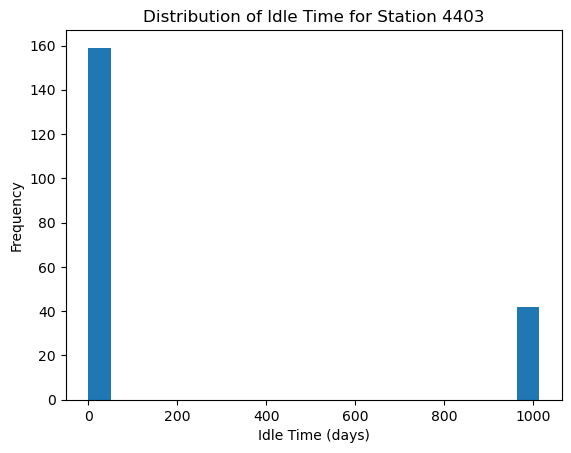

C:\Users\moham\AppData\Local\Temp\ipykernel_5500\4170074637.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['start_time'] = pd.to_datetime(station_data["start_time"])
C:\Users\moham\AppData\Local\Temp\ipykernel_5500\4170074637.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['end_time'] = pd.to_datetime(station_data["end_time"])
C:\Users\moham\AppData\Local\Temp\ipykernel_5500\4170074637.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

       Trip            End Time     Next Start Time
0   1532899 2020-02-23 13:58:00 2022-12-04 14:54:00
1   1532899 2020-02-23 13:58:00 2022-12-04 14:54:00
2   1532899 2020-02-23 14:00:00 2022-12-04 14:54:00
3   1532899 2020-02-23 14:02:00 2022-12-04 14:54:00
4   1532899 2020-02-23 14:02:00 2022-12-04 14:54:00
5   1532899 2020-02-23 14:05:00 2022-12-04 14:54:00
6   1532899 2020-02-23 14:07:00 2022-12-04 14:54:00
7   1532899 2020-02-23 14:07:00 2022-12-04 14:54:00
8   1532899 2020-02-23 14:09:00 2022-12-04 14:54:00
9   1532899 2020-02-23 14:10:00 2022-12-04 14:54:00
10  1532899 2020-02-23 14:10:00 2022-12-04 14:54:00
11  1532899 2020-02-23 14:10:00 2022-12-04 14:54:00
12  1532899 2020-02-23 14:11:00 2022-12-04 14:54:00
13  1532899 2020-02-23 14:11:00 2022-12-04 14:54:00
14  1532899 2020-02-23 14:14:00 2022-12-04 14:54:00
15  1532899 2020-02-23 14:15:00 2022-12-04 14:54:00
16  1532899 2020-02-23 14:16:00 2022-12-04 14:54:00
17  1532899 2020-02-23 14:18:00 2022-12-04 14:54:00
18  1532899 

In [11]:
sorted_df = result.sort_values(by='idle_time', ascending=False)

print(sorted_df.head())

full_data = merged_set_descriptive.copy()
station_data = full_data[(full_data['start_station_id'] == 4403) | (full_data['end_station_id'] == 4403)]
station_data['idle_time'] = pd.to_timedelta(station_data['idle_time']).dt.total_seconds() / (24 * 60 * 60)

plt.hist(station_data['idle_time'], bins=20)
plt.xlabel('Idle Time (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Idle Time for Station 4403')
plt.show()

station_data = full_data[(full_data['start_station_id'] == 4403) | (full_data['end_station_id'] == 4403)]
station_data['start_time'] = pd.to_datetime(station_data["start_time"])
station_data['end_time'] = pd.to_datetime(station_data["end_time"])
station_data['idle_time'] = pd.to_timedelta(station_data['idle_time'])
long_idle_trips = station_data[station_data["idle_time"] > pd.Timedelta(days=1000)]
long_idle_trips = long_idle_trips.sort_values('end_time')
comparison_results = pd.DataFrame(columns=['Trip', 'End Time', 'Next Start Time'])
for index, row in long_idle_trips.iterrows():
    end_time = row['end_time']
    for index, row in station_data.iterrows():
        if row["start_time"] > end_time:
            next_start_time = row["start_time"]
    comparison_results = pd.concat([comparison_results, pd.DataFrame({'Trip': [index], 'End Time': [end_time], 'Next Start Time': [next_start_time]})], ignore_index=True)

print(comparison_results)


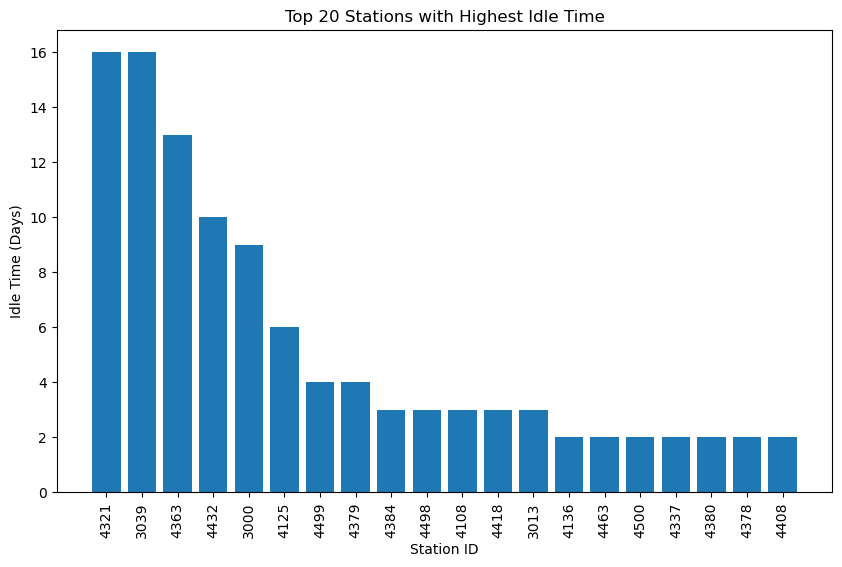

In [18]:
filtered_df = sorted_df[sorted_df['idle_time'] <= pd.Timedelta(days=30)]
top_20_stations = filtered_df.head(20)
top_20_stations = top_20_stations.reset_index()
top_20_stations["end_station_id"] = top_20_stations["end_station_id"].astype(str)
plt.figure(figsize=(10, 6))
plt.bar(top_20_stations["end_station_id"], top_20_stations["idle_time"].dt.days)
plt.title("Top 20 Stations with Highest Idle Time")
plt.xlabel("Station ID")
plt.ylabel("Idle Time (Days)")
plt.xticks(rotation=90)
plt.show()


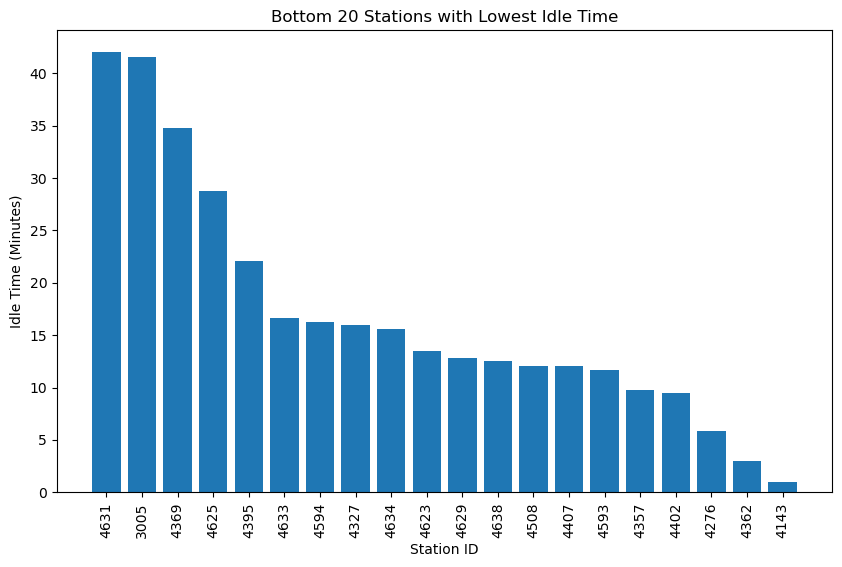

In [19]:

bottom_20_stations = filtered_df.tail(20)
bottom_20_stations = bottom_20_stations.reset_index()
bottom_20_stations["end_station_id"] = bottom_20_stations["end_station_id"].astype(str)
plt.figure(figsize=(10, 6))
plt.bar(bottom_20_stations["end_station_id"], bottom_20_stations["idle_time"].dt.total_seconds()/60)
plt.title("Bottom 20 Stations with Lowest Idle Time")
plt.xlabel("Station ID")
plt.ylabel("Idle Time (Minutes)")
plt.xticks(rotation=90)
plt.show()


In [24]:

print(filtered_df.count())
filtered_df = filtered_df.reset_index()
top_50_percent = filtered_df.head(197)
bottom_50_percent = filtered_df.tail(196)



avg_idle_time_top_50 = top_50_percent["idle_time"].mean()
avg_idle_time_bottom_50 = bottom_50_percent["idle_time"].mean()
over_top_avg_df = top_50_percent[top_50_percent["idle_time"] >= avg_idle_time_top_50]
under_bottom_avg_df = bottom_50_percent[bottom_50_percent["idle_time"] <= avg_idle_time_bottom_50]


idle_time          393
morgens            393
vormittags         393
mittags            393
nachmittags        393
abends             393
nachts             393
monday             393
tuesday            393
wednesday          393
thursday           393
friday             393
saturday           393
sunday             393
end_station_lat    393
end_station_lon    393
dtype: int64


In [30]:

over_top_avg_df["neighboring_stations"] = None
over_top_avg_df["avg_neighbor_idle_time"] = None

for i, row in over_top_avg_df.iterrows():
    station_id = row['end_station_id']
    lat = row['end_station_lat']
    lon = row['end_station_lon']
    center_coords = (lat, lon)
    neighbor_idle_time_sum = pd.Timedelta(0)
    neighboring_stations = []
    for index, sorted_row in filtered_df.iterrows():
        station_coords = (sorted_row['end_station_lat'], sorted_row['end_station_lon'])
        dist = distance.distance(center_coords, station_coords).meters
        if dist <= 500:
            neighboring_stations.append(sorted_row["end_station_id"])
            neighbor_idle_time_sum += pd.Timedelta(sorted_row["idle_time"])
    over_top_avg_df.at[i, "neighboring_stations"] = neighboring_stations
    over_top_avg_df.at[i, "avg_neighbor_idle_time"] = neighbor_idle_time_sum / len(neighboring_stations)


under_bottom_avg_df["neighboring_stations"] = None
under_bottom_avg_df["avg_neighbor_idle_time"] = None
for i, row in under_bottom_avg_df.iterrows():
    station_id = row['end_station_id']
    lat = row['end_station_lat']
    lon = row['end_station_lon']
    center_coords = (lat, lon)
    neighbor_idle_time_sum = pd.Timedelta(0)
    neighboring_stations = []
    for index, sorted_row in filtered_df.iterrows():
        station_coords = (sorted_row['end_station_lat'], sorted_row['end_station_lon'])
        dist = distance.distance(center_coords, station_coords).meters
        if dist <= 500:
            neighboring_stations.append(sorted_row["end_station_id"])
            neighbor_idle_time_sum += pd.Timedelta(sorted_row["idle_time"])

    under_bottom_avg_df.at[i, "neighboring_stations"] = neighboring_stations
    under_bottom_avg_df.at[i, "avg_neighbor_idle_time"] = neighbor_idle_time_sum / len(neighboring_stations)

C:\Users\moham\AppData\Local\Temp\ipykernel_5500\840481995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_top_avg_df["neighboring_stations"] = None
C:\Users\moham\AppData\Local\Temp\ipykernel_5500\840481995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_top_avg_df["avg_neighbor_idle_time"] = None


C:\Users\moham\AppData\Local\Temp\ipykernel_5500\840481995.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  under_bottom_avg_df["neighboring_stations"] = None
C:\Users\moham\AppData\Local\Temp\ipykernel_5500\840481995.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  under_bottom_avg_df["avg_neighbor_idle_time"] = None


,end_station_id,idle_time,morgens,vormittags,mittags,nachmittags,abends,nachts,monday,tuesday,wednesday,thursday,friday,saturday,sunday,end_station_lat,end_station_lon,neighboring_stations,avg_neighbor_idle_time
0,4321,16 days 08:02:23.571428571,13,15,16,14,11,12,3,6,6,5,9,5,5,[34.031399],[-118.453629],"[4321, 4546]",8 days 07:29:27.104110511
1,3039,16 days 06:44:38.608695652,36,59,93,63,34,34,34,34,34,34,34,34,113,[34.024479],[-118.393867],"[3039, 4393, 4330, 4548, 4558, 4369]",2 days 21:28:52.972467850
2,4363,13 days 15:34:22.466666666,12,13,12,8,11,12,6,6,9,10,10,9,8,[34.03046],[-118.389099],"[4363, 4372, 4356]",4 days 22:12:59.675279962
3,4432,10 days 23:02:06.598639455,87,94,110,120,91,76,52,61,66,46,56,53,56,[34.139568],[-118.362251],[4432],10 days 23:02:06.598639455
4,3000,9 days 05:12:06.872673225,24159,24135,23267,21077,20537,23368,16863,16607,16410,16415,16576,17174,18639,[34.0485],[-118.258537],"[3000, 4286, 4516, 4285, 3063, 3032, 3008, 300...",0 days 21:18:13.076252199


In [34]:

to_be_removed = []
for i, zeile in over_top_avg_df.iterrows():
    if zeile["idle_time"] > zeile["avg_neighbor_idle_time"] and len(zeile["neighboring_stations"]) > 2:
        to_be_removed.append(zeile["end_station_id"])

to_be_expanded = []
for i, zeile in under_bottom_avg_df.iterrows():
    if zeile["idle_time"] < zeile["avg_neighbor_idle_time"] and len(zeile["neighboring_stations"]) < 3:
        to_be_expanded.append(zeile["end_station_id"])

print(to_be_removed)
print(len(to_be_removed))
print(to_be_expanded)
print(len(to_be_expanded))


[3039, 4363, 3000, 4379, 4384, 4418, 4463, 4500, 4337, 4380, 4408, 4394, 4338, 4332, 4373, 4213, 4374, 4385, 4341, 4417, 4413, 4598, 4462]
23
[4587, 4632, 4626, 3014, 4594, 4327, 4623, 4629, 4276, 4362]
10


In [35]:

la_coordinates = (34.0522, -118.2437)
map_la = folium.Map(location=la_coordinates, zoom_start=11)
for index, row in filtered_df.iterrows():
    station_id = row['end_station_id']
    lat = row['end_station_lat']
    lon = row['end_station_lon']
    if station_id in to_be_expanded:
        folium.Marker(location=[lat, lon], tooltip=[str(station_id)], icon = folium.Icon(color="green")).add_to(map_la)
    elif station_id in to_be_removed:
        folium.Marker(location=[lat, lon], tooltip=[str(station_id)], icon = folium.Icon(color="red")).add_to(map_la)
    else:
        folium.Marker(location=[lat, lon], tooltip=[str(station_id)]).add_to(map_la)
map_la

In [ ]:
merged_set_pred = merged_set.dropna(subset=["idle_time"])
merged_set_pred['idle_time'] = merged_set_pred['idle_time'].dt.total_seconds()/3600
merged_set_pred['end_hour'] = merged_set_pred['end_time'].dt.hour

le = LabelEncoder()
merged_set_pred['cloud_cover_description'] = le.fit_transform(merged_set_pred['cloud_cover_description'])

In [ ]:
# Define target variable
y = merged_set_pred['idle_time'].values

# Define features
X = merged_set_pred.drop(['start_time', 'end_time', 'bike_id', 'idle_time', 'start_station_id','start_station_lat','start_station_lon'], axis=1)

# Extract feature names
feature_names = X.columns.tolist()

# Perform train-validation-test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.285, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)



In [ ]:
# Define the parameter lgbm_grid
param_grid = {
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 1],
    'num_leaves': [31, 62, 93],
    'n_estimators': [100, 200, 300]
}

# Create a LightGBM model
lgbm_model = lgb.LGBMRegressor()

# Create the lgbm_grid search object
lgbm_grid = GridSearchCV(lgbm_model, param_grid, cv=5, scoring='r2')

# Fit the lgbm_grid search object to the data
lgbm_grid.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(lgbm_grid.best_params_)
print(lgbm_grid.best_score_)

In [ ]:
# Define the parameter tree_grid
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Create a DecisionTreeRegressor model
decTree_model = DecisionTreeRegressor()

# Create the tree_grid search object
tree_grid = GridSearchCV(decTree_model, param_grid, cv=5, scoring='r2')

# Fit the tree_grid search object to the data
tree_grid.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(tree_grid.best_params_)
print(tree_grid.best_score_)

In [ ]:
y_pred_tree = tree_grid.best_estimator_.predict(X_val)
y_pred_lgbm = lgbm_grid.best_estimator_.predict(X_val)

mse_tree = mean_squared_error(y_val, y_pred_tree)
mae_tree = mean_absolute_error(y_val, y_pred_tree)
r2_tree = r2_score(y_val, y_pred_tree)
mse_lgbm = mean_squared_error(y_val, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_val, y_pred_lgbm)
r2_lgbm = r2_score(y_val, y_pred_lgbm)

models = ['Decision Tree', 'LightGBM']
mse_values = [mse_tree, mse_lgbm]
mae_values = [mae_tree, mae_lgbm]
r2_values = [r2_tree, r2_lgbm]

def comparison_plot(values, title, ylabel):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=models, y=values, palette='viridis')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()


comparison_plot(mse_values, 'Comparison of Mean Squared Error', 'MSE')
comparison_plot(mae_values, 'Comparison of Mean Absolute Error', 'MAE')
comparison_plot(r2_values, 'Comparison of R2 Score', 'R2 Score')

In [ ]:
best_params_tree = tree_grid.best_params_
best_params_lgbm = lgbm_grid.best_params_
base_models = [
    ('decision_tree', DecisionTreeRegressor(**best_params_tree)),
    ('lgbm', LGBMRegressor(**best_params_lgbm))
]

# Define the meta model
meta_model = Lasso()

final_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
final_model.fit(X_train, y_train)

In [ ]:
y_pred_final = final_model.predict(X_val)
mse_final = mean_squared_error(y_val, y_pred_final)
mae_final = mean_absolute_error(y_val, y_pred_final)
r2_final = r2_score(y_val, y_pred_final)

models.append('StackingRegressor')
mse_values.append(mse_final)
mae_values.append(mae_final)
r2_values.append(r2_final)

comparison_plot(mse_values, 'Comparison of Mean Squared Error', 'MSE')
comparison_plot(mae_values, 'Comparison of Mean Absolute Error', 'MAE')
comparison_plot(r2_values, 'Comparison of R2 Score', 'R2 Score')

In [ ]:
val_preds = final_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_preds)
val_mae = mean_absolute_error(y_val, val_preds)
val_r2 = r2_score(y_val, val_preds)

test_preds = final_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_mae = mean_absolute_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

print('Validation MSE:', val_mse)
print('Validation MAE:', val_mae)
print('Validation R2:', val_r2)

print('Test MSE:', test_mse)
print('Test MAE:', test_mae)
print('Test R2:', test_r2)

labels = ['MSE', 'MAE', 'R2']
val_values = [val_mse, val_mae, val_r2]
test_values = [test_mse, test_mae, test_r2]

#Create a figure with three subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# For each metric, create a bar plot comparing the validation and test values
for i in range(3):
    ax[i].bar(['Validation', 'Test'], [val_values[i], test_values[i]], color=['blue', 'green'])
    ax[i].set_title(labels[i])
    ax[i].set_ylabel(labels[i])

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()